# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам

# <center>Неделя 2. Подготовка и первичный анализ данных

На второй неделе мы продолжим подготавливать данные для дальнейшего анализа и построения прогнозных моделей. Конкретно, раньше мы определили что сессия – это последовательность из 10 посещенных пользователем сайтов, теперь сделаем длину сессии параметром, и потом при обучении прогнозных моделей выберем лучшую длину сессии.
Также мы познакомимся с предобработанными данными и статистически проверим первые гипотезы, связанные с нашими наблюдениями. 

**План 2 недели:**
 - Часть 1. Подготовка нескольких обучающих выборок для сравнения
 - Часть 2. Первичный анализ данных

   
**Кроме того, в задании будут использоваться библиотеки Python [glob](https://docs.python.org/3/library/glob.html), [pickle](https://docs.python.org/2/library/pickle.html), [itertools](https://docs.python.org/3/library/itertools.html) и класс [csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) из scipy.sparse.**

## Часть 1. Подготовка нескольких обучающих выборок для сравнения

Пока мы брали последовательности из 10 сайтов, и это было наобум. Давайте сделаем число сайтов в сессии параметром, чтоб в дальнейшем сравнить модели классификации, обученные на разных выборках – с 5, 7, 10 и 15 сайтами в сессии. Более того, пока мы брали по 10 сайтов подряд, без пересечения. Теперь давайте применим идею скользящего окна – сессии будут перекрываться. 

**Пример**: для длины сессии 10 и ширины окна 7 файл из 30 записей породит не 3 сессии, как раньше (1-10, 11-20, 21-30), а 5 (1-10, 8-17, 15-24, 22-30, 29-30). При этом в предпоследней сессии будет один ноль, а в последней – 8 нолей.

Создадим несколько выборок для разных сочетаний параметров длины сессии и ширины окна. Все они представлены в табличке ниже:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">session_length -&gt;<br>window_size <br></th>
    <th class="tg-031e">5</th>
    <th class="tg-031e">7</th>
    <th class="tg-031e">10</th>
    <th class="tg-031e">15</th>
  </tr>
  <tr>
    <td class="tg-031e">5</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">7</td>
    <td class="tg-031e"></td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
    <td class="tg-031e">v</td>
  </tr>
  <tr>
    <td class="tg-031e">10</td>
    <td class="tg-031e"></td>
    <td class="tg-031e"></td>
    <td class="tg-031e"><font color='green'>v</font></td>
    <td class="tg-031e">v</td>
  </tr>
</table>

Итого должно получиться 18 разреженных матриц – указанные в таблице 9 сочетаний параметров формирования сессий для выборок из 10 и 150 пользователей. При этом 2 выборки мы уже сделали в прошлой части, они соответствуют сочетанию параметров: session_length=10, window_size=10, которые помечены в таблице выше галочкой зеленого цвета (done).

Реализуйте функцию *prepare_sparse_train_set_window*.

Аргументы:
- *path_to_csv_files* – путь к каталогу с csv-файлами
- *site_freq_path* – путь к pickle-файлу с частотным словарем, полученным в 1 части проекта
- *session_length* – длина сессии (параметр)
- *window_size* – ширина окна (параметр) 

Функция должна возвращать 2 объекта:
- разреженную матрицу *X_sparse* (двухмерная Scipy.sparse.csr_matrix), в которой строки соответствуют сессиям из *session_length* сайтов, а *max(site_id)* столбцов – количеству посещений *site_id* в сессии. 
- вектор *y* (Numpy array) "ответов" в виде ID пользователей, которым принадлежат сессии из *X_sparse*

Детали:
- Модифицируйте созданную в 1 части функцию *prepare_train_set*
- Некоторые сессии могут повторяться – оставьте как есть, не удаляйте дубликаты
- Замеряйте время выполнения итераций цикла с помощью *time* из *time*, *tqdm* из *tqdm* или с помощью виджета [log_progress](https://github.com/alexanderkuk/log-progress) ([статья](https://habrahabr.ru/post/276725/) о нем на Хабрахабре)
- 150 файлов из *capstone_websites_data/150users/* должны обрабатываться за несколько секунд (в зависимости от входных параметров). Если дольше – не страшно, но знайте, что функцию можно ускорить. 

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
%matplotlib inline
from matplotlib import pyplot as plt
import glob
import re

In [3]:
PATH_TO_DATA = 'D:\!User\Downloads\DS\HW05\capstone_user_identification'
site_freq_path = os.path.join(PATH_TO_DATA,'site_freq_3users.pkl')


In [4]:
def prepare_train_set_window(path_to_csv_files,site_freq_path, 
                                    session_length, window_size):
    df = pd.DataFrame()
    data = pd.DataFrame()
    csv_file_path = glob.glob(path_to_csv_files)
    series = []
    for file in csv_file_path:
        df = pd.read_csv(file)
        series.append(df['site'])                                             
    #считываем все файлы и добавляем в серии
        
    with open(site_freq_path, 'rb') as site_freq_file:
        dictionary = pickle.load(site_freq_file)
    #считываем сохраненный словарь
                
    user_ids = [int(re.search('([1-9][0-9]*).csv$', path).group(1)) for path in csv_file_path]
    #получим список юзеров
    
    list = []
    for index, sites in enumerate(series):
        #определим размер сессии для каждого юзера
        line = sites.shape[0]
        rows = line // window_size if line % window_size == 0 else line // window_size + 1
        lines = rows * window_size
        session = np.empty(lines, dtype=int)
        print(session)
        zeros = lines - line
        if zeros > 0:
            session[-zeros:] = 0
        #заполним нолями неполные сессии
        for i, site in enumerate(sites):
            session[i] = dictionary[site][0]
        #присвоим сайтам номера из словаря
        session = np.pad(session, (0, int(np.ceil(len(session)\
                /window_size)) * window_size- len(session)), mode='constant').reshape(-1, window_size)
        print(session)
        size = session_length-window_size
        if size > 0:
            session2 = np.vstack([session, np.repeat(0, size)])[1:session.shape[0]+1,]
            session1 = np.concatenate((session, session2),axis=1)
            sessions = pd.DataFrame(session1.reshape(-1, session_length), columns=np.arange(1, session_length+1)) \
               .add_prefix('site').assign(user_id = user_ids[index])
        else:
            sessions = pd.DataFrame(session.reshape(-1, session_length), columns=np.arange(1, session_length+1)) \
               .add_prefix('site').assign(user_id = user_ids[index])
        list.append(sessions)
    features = pd.concat(list, ignore_index = True)
    return features
dataFrame = prepare_train_set_window(os.path.join(PATH_TO_DATA, "3users", "*.csv"), 
                                os.path.join(PATH_TO_DATA,'site_freq_3users.pkl'), 
                                     session_length=10, window_size=5)
dataFrame    



[130220031         0 130216144         0 162926464         0 130216299
         0 130216083         0 130216113         0 130216217         0
 130216155]
[[ 4  2  2 11  2]
 [ 1  7  6 10  8]
 [ 4  1  1  1  0]]
[0 0 0 0 0]
[[4 2 5 5 2]]
[ 4  2  2 11  2  1  7  6 10  8  4  1  1  1  0]
[[3 1 2 1 2]
 [1 1 6 9 3]
 [3 1 2 0 0]]


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
0,4,2,2,11,2,1,7,6,10,8,1
1,1,7,6,10,8,4,1,1,1,0,1
2,4,1,1,1,0,0,0,0,0,0,1
3,4,2,5,5,2,0,0,0,0,0,2
4,3,1,2,1,2,1,1,6,9,3,3
5,1,1,6,9,3,3,1,2,0,0,3
6,3,1,2,0,0,0,0,0,0,0,3


In [5]:
df = pd.DataFrame()
data = pd.DataFrame()
session_length=10
window_size=5
path_to_csv_files= os.path.join(PATH_TO_DATA, "3users", "*.csv")
site_freq_path = os.path.join(PATH_TO_DATA,'site_freq_3users.pkl')
csv_file_path = glob.glob(path_to_csv_files)
series = []
for file in csv_file_path:
    df = pd.read_csv(file)
    series.append(df['site'])  
with open(site_freq_path, 'rb') as site_freq_file:
    dictionary = pickle.load(site_freq_file)
             
user_ids = [int(re.search('([1-9][0-9]*).csv$', path).group(1)) for path in csv_file_path]
list = []
session = pd.DataFrame()
for index, sites in enumerate(series):
    line = sites.shape[0]
    rows = line // window_size if line % session_length == 0 else line // window_size + 1
    lines = rows * window_size
    session = np.empty(lines, dtype=int)
    zeros = lines - line
    if zeros > 0:
        session[-zeros:] = 0
        #заполним нолями неполные сессии
    for i, site in enumerate(sites):
        session[i] = dictionary[site][0]
        #присвоим сайтам номера из словаря
    session = np.pad(session, (0, int(np.ceil(len(session)\
         /window_size)) * window_size- len(session)), mode='constant').reshape(-1, window_size)
    session = pd.DataFrame(session)
    
    session4 = session.iloc[1:session.shape[0]+1,]
    #sessions = np.hstack((session, session4))
session

,0,1,2,3,4
0,3,1,2,1,2
1,1,1,6,9,3
2,3,1,2,0,0


In [6]:
session4

,0,1,2,3,4
1,1,1,6,9,3
2,3,1,2,0,0


In [12]:
def make_sparse_data(data):
    indptr = [0]
    indices = []
    sparse_data = []
    for row in data:
        val, cnt = np.unique(row[row != 0], return_counts=True)
        indptr.append(indptr[-1] + len(val))
        for v, c in zip(val, cnt):
            indices.append(v - 1)
            sparse_data.append(c)
    return np.uint64(sparse_data),  np.uint64(indices), np.uint64(indptr)

In [13]:
def prepare_sparse_train_set_window(csv_files_mask, site_freq_path, 
                                    session_length=10, window_size=10):
    data = prepare_train_set_window(csv_files_mask, 
                                    site_freq_path, 
                                    session_length=session_length, 
                                    window_size = window_size)
    X, y = data.iloc[:, :-1].values, data.iloc[:, -1].values
    X_sparse = csr_matrix(make_sparse_data(X)) 
    return X_sparse, y

In [14]:
X_toy_s5_w3, y_s5_w3 = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA, "3users", "*.csv"), 
                                os.path.join(PATH_TO_DATA,'site_freq_3users.pkl'), 
                                     session_length=10, window_size=5)

In [15]:
X_toy_s5_w3.todense()

matrix([[1, 3, 0, 1, 0, 1, 1, 1, 0, 1, 1],
        [4, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0],
        [3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [4, 2, 2, 0, 0, 1, 0, 0, 1, 0, 0],
        [3, 1, 2, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint64)

In [11]:
X_toy_s5_w3.todense()

matrix([[1, 3, 0, 1, 0, 1, 1, 1, 0, 1, 1],
        [4, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0],
        [3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [4, 2, 2, 0, 0, 1, 0, 0, 1, 0, 0],
        [3, 1, 2, 0, 0, 1, 0, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint64)

In [3]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, 
                                    session_length=10, window_size=10):
    ''' ВАШ КОД ЗДЕСЬ'''

**Примените полученную функцию с параметрами *session_length=5* и *window_size=3* к игрушечному примеру. Убедитесь, что все работает как надо.**

In [149]:
X_toy_s5_w3, y_s5_w3 = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA,'3users'), 
                                                       os.path.join(PATH_TO_DATA,'site_freq_3users.pkl'),
                                       session_length=5, window_size=3)

In [8]:
X_toy_s5_w3.todense()

matrix([[0, 3, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0],
        [3, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [9]:
y_s5_w3

array([1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3])

**Запустите созданную функцию 16 раз с помощью циклов по числу пользователей num_users (10 или 150), значениям параметра *session_length* (15, 10, 7 или 5) и значениям параметра *window_size* (10, 7 или 5). Сериализуйте все 16 разреженных матриц (обучающие выборки) и векторов (метки целевого класса – ID пользователя) в файлы `X_sparse_{num_users}users_s{session_length}_w{window_size}.pkl` и `y_{num_users}users_s{session_length}_w{window_size}.pkl`.**

**Чтоб убедиться, что мы все далее будем работать с идентичными объектами, запишите в список *data_lengths* число строк во всех полученных рареженных матрицах (16 значений). Если какие-то будут совпадать, это нормально (можно сообразить, почему).**

**На моем ноутбуке этот участок кода отработал за 26 секунд, хотя понятно, что все зависит от эффективности реализации функции *prepare_sparse_train_set_window* и мощности используемого железа. И честно говоря, моя первая реализация была намного менее эффективной (34 минуты), так что тут у Вас есть возможность оптимизировать свой код.**

In [ ]:
%%time
import itertools

data_lengths = []

for num_users in [10, 150]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length) != (10, 10):
            X_sparse, y = ''' ВАШ КОД ЗДЕСЬ '''

**<font color='red'> Вопрос 1. </font>Сколько всего уникальных значений в списке `data_lengths`?**

In [9]:
''' ВАШ КОД ЗДЕСЬ '''

## Часть 2. Первичный анализ данных

**Считаем в DataFrame подготовленный на 1 неделе файл `train_data_10users.csv`. Далее будем работать с ним.**

In [10]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), 
                       index_col='session_id')

In [11]:
train_df.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,user_id
session_id,,,,,,,,,,,
0,193,574,133,3,133,133,3,133,203,133,31
1,415,192,675,254,133,31,393,3634,217,55,31
2,55,3,55,55,5,293,415,333,900,55,31
3,473,3395,473,55,55,55,55,944,199,123,31
4,342,55,5,3458,258,211,3369,2096,674,2096,31


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14061 entries, 0 to 14060
Data columns (total 11 columns):
site1      14061 non-null int64
site2      14061 non-null int64
site3      14061 non-null int64
site4      14061 non-null int64
site5      14061 non-null int64
site6      14061 non-null int64
site7      14061 non-null int64
site8      14061 non-null int64
site9      14061 non-null int64
site10     14061 non-null int64
user_id    14061 non-null int64
dtypes: int64(11)
memory usage: 1.3 MB


**Распределение целевого класса:**

In [13]:
train_df['user_id'].value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: user_id, dtype: int64

**Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.**

In [14]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0] 
                    for i in range(train_df.shape[0])]

In [15]:
pd.Series(num_unique_sites).value_counts()

7     2308
6     2197
8     2046
5     1735
9     1394
2     1246
4     1163
3      894
10     651
1      427
dtype: int64

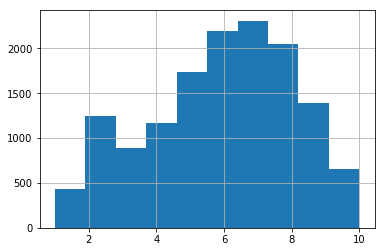

In [16]:
pd.Series(num_unique_sites).hist();

На 3 неделе мы займемся визуальным анализом данных и построением признаков.